# Matrix Factorisation - Implicit

Implicit Matrix Factorization 

- Where ratings of less than threshold are implied as preferences
- Also uses negative sampling to improve performance

In [1]:
import sys
sys.path.append("../")

import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
from IPython.display import SVG, display
import matplotlib.pyplot as plt
import seaborn as sns
from reco.preprocess import encode_user_item_withencoder, random_split, user_split, neg_feedback_samples
from reco.evaluate import user_item_crossjoin, filter_by

In [3]:
%matplotlib inline

### Prepare the data

In [4]:
df_ratings = pd.read_csv("data/ratings.csv")
df_items = pd.read_csv("data/items.csv")

In [5]:
df_implicit = neg_feedback_samples(df_ratings, rating_threshold=3, ratio_neg_per_user=1)
df_implicit["unix_timestamp"] = 1

In [6]:
df_implicit.head()

,user_id,movie_id,rating,unix_timestamp
0,1,61,1,1
298,1,866,0,1
297,1,510,0,1
296,1,102,0,1
295,1,886,0,1


In [7]:
df_ratings.shape, df_implicit.shape

((100000, 4), (165040, 4))

In [8]:
# Data Encoding
DATA, user_encoder, item_encoder = encode_user_item_withencoder(df_implicit, "user_id", "movie_id", "rating", "unix_timestamp")

Number of users:  943
Number of items:  1682


In [9]:
n_users = DATA.USER.nunique()
n_items = DATA.ITEM.nunique()
n_users, n_items

(943, 1682)

In [10]:
max_rating = DATA.RATING.max()
min_rating = DATA.RATING.min()
min_rating, max_rating

(0, 1)

In [11]:
# Data Splitting
#train, val, test = user_split(DATA, [0.6, 0.2, 0.2])
train, test = random_split(DATA, [0.8, 0.2])

In [12]:
train.shape, test.shape

((132032, 5), (33008, 5))

## Implicit Matrix Factorisation 

This is a model with User and Item Embedding Dot Product

In [13]:
from keras.models import Model
from keras.layers import Input, Embedding, Flatten, Dot, Add, Lambda, Activation, Reshape
from keras.regularizers import l2
from keras.constraints import non_neg
from keras.utils import plot_model
from keras.utils import model_to_dot
#from reco import vis

### Build the Model

In [14]:
def ImplicitMF (n_users, n_items, n_factors):
    
    # Item Layer
    item_input = Input(shape=[1], name='Item')
    item_embedding = Embedding(n_items, n_factors, 
                               embeddings_regularizer=l2(1e-6), 
                               name='ItemEmbedding')(item_input)
    item_vec = Flatten(name='FlattenItemsE')(item_embedding)

    # User Layer
    user_input = Input(shape=[1], name='User')
    user_embedding = Embedding(n_users, n_factors, 
                               embeddings_regularizer=l2(1e-6), 
                               name='UserEmbedding')(user_input)
    user_vec = Flatten(name='FlattenUsersE')(user_embedding)

    # Dot Product of Item and User
    rating = Dot(axes=1, name='DotProduct')([item_vec, user_vec])
    
    # Model Creation
    model = Model([user_input, item_input], rating)
    
    # Compile Model
    model.compile(loss='binary_crossentropy', optimizer="sgd")
    
    return model

In [15]:
n_factors = 40
model = ImplicitMF(n_users, n_items, n_factors)

In [16]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Item (InputLayer)             │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ User (InputLayer)             │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ ItemEmbedding (Embedding)     │ (None, 1, 40)             │          67,280 │ Item[0][0]                 │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ UserEmbedding (Embedding)     │ (None, 1, 40)             │          37,720 │ User[0][0]                 │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ FlattenItemsE (Flatten)       │ (None, 40)                │               0 │ ItemEmbedding[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ FlattenUsersE (Flatten)       │ (None, 40)                │               0 │ UserEmbedding[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ DotProduct (Dot)              │ (None, 1)                 │               0 │ FlattenItemsE[0][0],       │
│                               │                           │                 │ FlattenUsersE[0][0]        │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 105,000 (410.16 KB)

 Trainable params: 105,000 (410.16 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
from reco.recoutils import create_directory
create_directory("/model-img")

Directory already exists C:\Users\sadha\OneDrive\Desktop\Movie Recommendation System/model-img


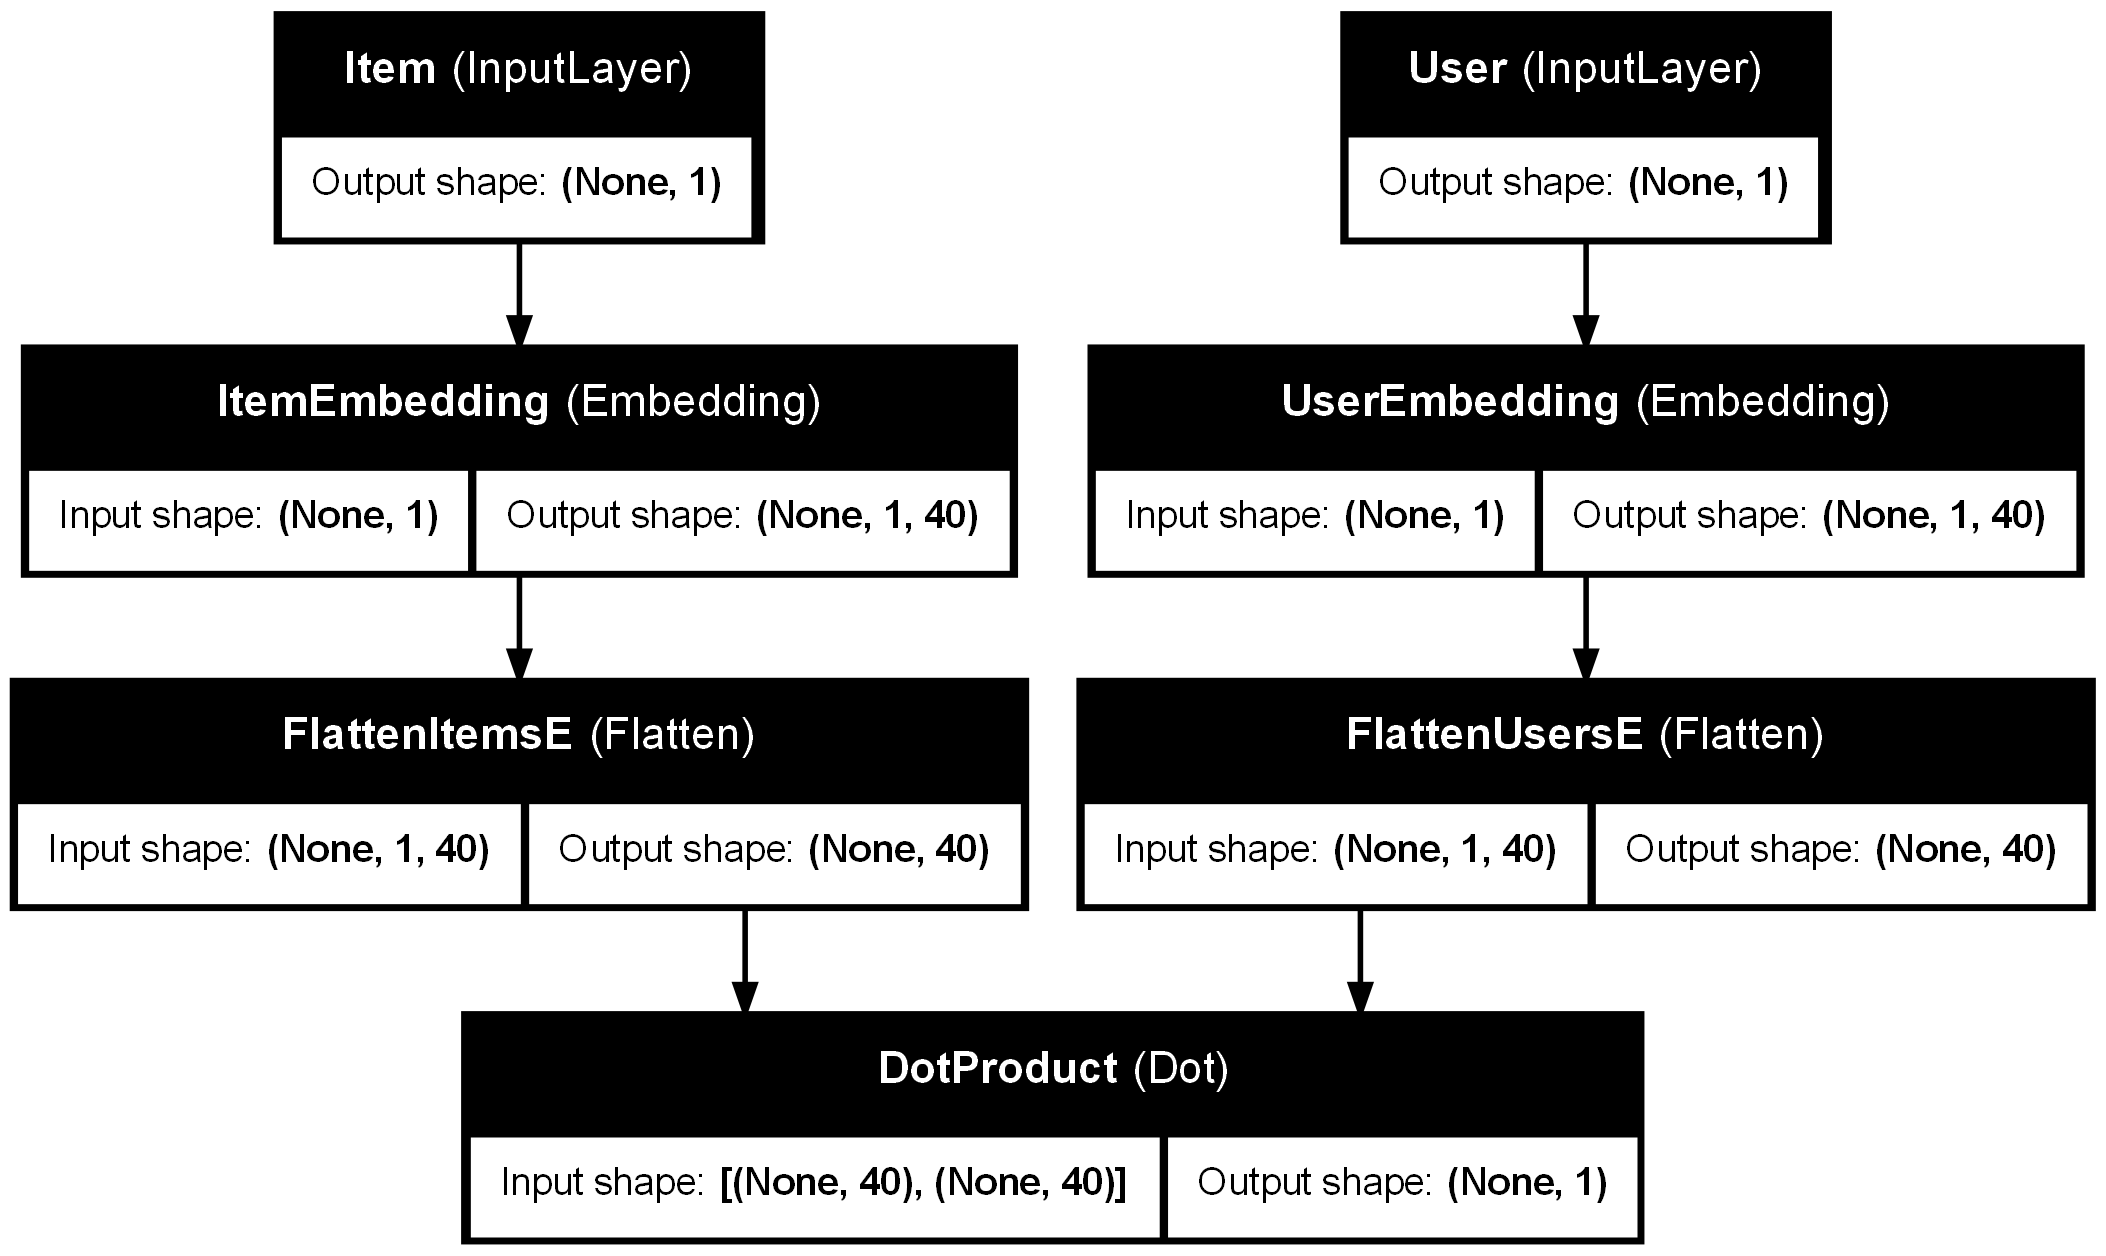

In [18]:
plot_model(model, show_layer_names=True, show_shapes=True, to_file="model-img/implicit-mf.png" )

### Train the Model

In [19]:
%%time
output = model.fit([train.USER, train.ITEM], train.RATING, 
                                  batch_size=128, epochs=5, verbose=1, validation_split=0.2)

Epoch 1/5
826/826 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 5.2682 - val_loss: 5.3390
Epoch 2/5
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 4.0239 - val_loss: 5.2913
Epoch 3/5
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 2.8612 - val_loss: 5.2765
Epoch 4/5
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 2.2591 - val_loss: 5.2636
Epoch 5/5
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.9456 - val_loss: 5.2815
Wall time: 11.7 s


In [20]:
#vis.metrics(output.history)

### Score the Model

In [21]:
score = model.evaluate([test.USER, test.ITEM], test.RATING, verbose=1)
score

1032/1032 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.5072


5.468647480010986

### Evaluate the Model

In [22]:
from reco.evaluate import get_embedding, get_predictions, recommend_topk
from reco.evaluate import precision_at_k, recall_at_k, ndcg_at_k

In [23]:
item_embedding = get_embedding(model, "ItemEmbedding")
user_embedding = get_embedding(model, "UserEmbedding")

In [24]:
%%time
predictions = get_predictions(model, DATA)

49567/49567 ━━━━━━━━━━━━━━━━━━━━ 74s 1ms/step
Wall time: 1min 58s


In [25]:
predictions.head()

,USER,ITEM,RATING_PRED
0,0,60,0.088555
1,0,865,0.065288
2,0,509,0.059294
3,0,101,0.051234
4,0,885,0.017705


In [26]:
%%time
# Recommendation for Top10K
ranking_topk = recommend_topk(model, DATA, train, k=5)

49567/49567 ━━━━━━━━━━━━━━━━━━━━ 69s 1ms/step
Wall time: 1min 41s


In [27]:
eval_precision = precision_at_k(test, ranking_topk, k=10)
eval_recall = recall_at_k(test, ranking_topk, k=10)
eval_ndcg = ndcg_at_k(test, ranking_topk, k=10)

print("NDCG@K:\t%f" % eval_ndcg,
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')

NDCG@K:	0.108089
Precision@K:	0.079798
Recall@K:	0.004263


### Get Similar Items

In [28]:
from reco.recommend import get_similar, show_similar

In [29]:
%%time
item_distances, item_similar_indices = get_similar(item_embedding, 5)

Wall time: 167 ms


In [30]:
item_similar_indices

array([[   0,  587,  434,  932,    4],
       [   1,  791,  317,  165,  908],
       [   2,  793,  373,  489,  488],
       ...,
       [1679, 1470, 1486,  593, 1382],
       [1680,  423, 1143, 1458,   34],
       [1681, 1435,  725, 1572, 1195]], dtype=int64)

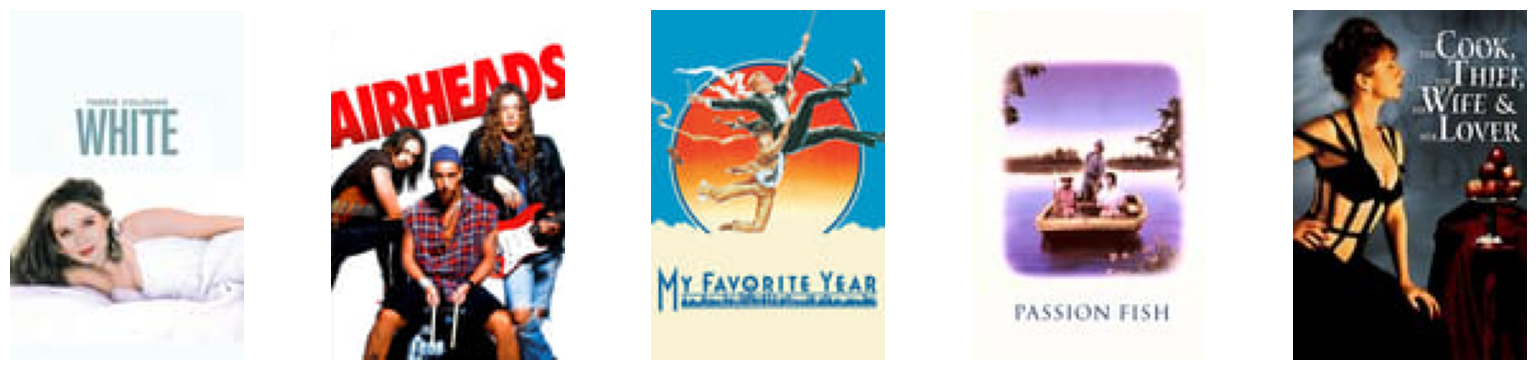

In [32]:
show_similar(60, item_similar_indices, item_encoder)